## Import data

In [1]:
import pandas as pd
df1 = pd.read_parquet("validated_data/cleaned1.parquet")
df2 = pd.read_parquet("validated_data/cleaned2.parquet")
df3 = pd.read_parquet("validated_data/cleaned3.parquet")

dfs = [df1, df2, df3]
for i, df in enumerate(dfs):
    dfs[i] = df[df["Faulty"] == False]
    print(f"Building {i+1} has {len(dfs[i])} out of {len(df)} valid rows.")
df1, df2, df3 = dfs

Building 1 has 1058508 out of 2097150 valid rows.
Building 2 has 137790 out of 520938 valid rows.
Building 3 has 619925 out of 1942515 valid rows.


## Data preparation

Only keep columns with useful information.
- `Slab_temp` and `Dew_temp` values do not vary in building 1
- `building_no` is the same value within dataframes
- `Fan_on_group` and `Cumulative_fan_on_mins` values were calculated using the target variable `Fan_status`
- `Date` and `Time` cannot be easily converted to numeric values
- `Year` values should probably not be used for prediction
- `Damper_open_group` and `Louver_open_group` are categorical labels
- Cumulative metrics probably won't be available when trying to predict future values
- `Louver_status` values are missing in building 3

In [2]:
exclude = ["building_no", "Fan_on_group", "Date", "Time", "Year", "Damper_open_group", "Louver_open_group", "Faulty", "Cumulative_fan_on_mins", "Cumulative_damper_open_mins", "Cumulative_louver_open_mins"]
exclude_df1 = exclude + ["Slab_temp", "Dew_temp", "Slab_temp_diff", "Dew_temp_diff"]
exclude_df3 = exclude + ["Louver_status"]

df1 = df1[df1.columns.difference(exclude_df1)]
df2 = df2[df2.columns.difference(exclude)]
df3 = df3[df3.columns.difference(exclude_df3)]
dfs = [df1, df2, df3]

Use `Datetime` to get day of year and minutes past midnight

In [3]:
for df in dfs:
    df["Day_of_Year"] = df["Datetime"].dt.day_of_year
    df["Minutes_past_midnight"] = ((df["Datetime"] - df["Datetime"].dt.normalize()) / pd.Timedelta(minutes=1))
    #df["DOW"] = df["Datetime"].dt.day_name().astype("category")
    del df["Datetime"]

#import seaborn as sns
#sns.heatmap(df1[df1.columns.difference(["Fan_status", "Zone_name", "DOW"])].corr(), cmap="BrBG", vmin=-1, vmax=1)

Remove rows with `NA` values for columns that do not have many `NA` values.

In [4]:
for df in dfs:
    # limit to columns with less than 5% NA values
    cutoff = len(df) // 20

    sums = df.isna().sum()
    sums = sums[sums != 0]
    #print(cutoff)
    #print(sums)
    sums = sums[sums <= cutoff]
    df.dropna(subset=sums.index, inplace=True)


Encode `Zone_name` as numeric variables.

In [5]:
categorical_columns = ["Zone_name"]
#categorical_columns = ["Zone_name", "DOW"]
df1 = pd.get_dummies(df1, columns=categorical_columns)
dfs[0] = df1
df2 = pd.get_dummies(df2, columns=categorical_columns)
dfs[1] = df2
df3 = pd.get_dummies(df3, columns=categorical_columns)
dfs[2] = df3

## Split datasets into training and testing subsets
We use a 80% training, 10% validation, 10% testing split.

In [6]:
from sklearn.model_selection import train_test_split

train1, test1 = train_test_split(df1, test_size=0.2, random_state=42)
val1, test1 = train_test_split(test1, test_size=0.5, random_state=42)
train2, test2 = train_test_split(df2, test_size=0.2, random_state=42)
val2, test2 = train_test_split(test2, test_size=0.5, random_state=42)
train3, test3 = train_test_split(df3, test_size=0.2, random_state=42)
val3, test3 = train_test_split(test3, test_size=0.5, random_state=42)

Use random undersampling to handle unbalanced training sets.

In [7]:
target = "Fan_status"

for train in [train1, train2, train3]:
    counts = train[target].value_counts()
    if counts["On"] > counts["Off"] * 3:
        # data is already in random order, so we can just remove the relevant records after the cutoff
        drop = train[train[target] == "On"].index[counts["Off"] * 3:]
        train.drop(drop, inplace=True)
    elif counts["Off"] > counts["On"] * 3:
        drop = train[train[target] == "Off"].index[counts["On"] * 3:]
        train.drop(drop, inplace=True)

In [8]:
features1 = df1.columns.to_list()
features1.remove(target)
y_train1 = train1[target]
y_val1 = val1[target]
y_test1 = test1[target]
x_train1 = train1[features1]
x_val1 = val1[features1]
x_test1 = test1[features1]

features2 = df2.columns.to_list()
features2.remove(target)
y_train2 = train2[target]
y_val2 = val2[target]
y_test2 = test2[target]
x_train2 = train2[features2]
x_val2 = val2[features2]
x_test2 = test2[features2]

features3 = df3.columns.to_list()
features3.remove(target)
y_train3 = train3[target]
y_val3 = val3[target]
y_test3 = test3[target]
x_train3 = train3[features3]
x_val3 = val3[features3]
x_test3 = test3[features3]

## Evaluating Model Performance

In [9]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, average_precision_score, matthews_corrcoef
from sklearn.pipeline import Pipeline

def calculate_metrics(model: Pipeline, X: pd.Series, y: pd.Series, print_report = True):
    y_predict = model.predict(X)
    y_proba = model.predict_proba(X)[:,1]

    if print_report:
        print(classification_report(y, y_predict, digits=4))

    return {
        "Accuracy": accuracy_score(y, y_predict),
        "f1": f1_score(y, y_predict, pos_label="On"),
        "ROC AUC": roc_auc_score(y, y_proba),
        "PR AUC": average_precision_score(y, y_proba, pos_label="On"),
        "Matthews": matthews_corrcoef(y, y_predict)
    }

model_metrics = {f"Building {n+1}": {} for n in range(3)}

## Decision Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
model_name = "Decision Tree"

### Building 1

In [11]:
tree.fit(x_train1, y_train1)
model_metrics["Building 1"][model_name] = calculate_metrics(tree, x_val1, y_val1)

              precision    recall  f1-score   support

         Off     0.9991    0.9994    0.9993     27615
          On     0.9998    0.9997    0.9997     76071

    accuracy                         0.9996    103686
   macro avg     0.9995    0.9995    0.9995    103686
weighted avg     0.9996    0.9996    0.9996    103686



### Building 2

In [12]:
tree.fit(x_train2, y_train2)
model_metrics["Building 2"][model_name] = calculate_metrics(tree, x_val2, y_val2)

              precision    recall  f1-score   support

         Off     0.9844    0.9597    0.9719     11577
          On     0.7680    0.8978    0.8278      1722

    accuracy                         0.9517     13299
   macro avg     0.8762    0.9287    0.8999     13299
weighted avg     0.9564    0.9517    0.9532     13299



### Building 3

In [13]:
tree.fit(x_train3, y_train3)
model_metrics["Building 3"][model_name] = calculate_metrics(tree, x_val3, y_val3)

              precision    recall  f1-score   support

         Off     0.9919    0.9915    0.9917     46202
          On     0.9739    0.9753    0.9746     15039

    accuracy                         0.9875     61241
   macro avg     0.9829    0.9834    0.9832     61241
weighted avg     0.9875    0.9875    0.9875     61241



## Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

model_name = "Random Forest"
forest = RandomForestClassifier(random_state=42, n_jobs=-1)

### Building 1

<Axes: >

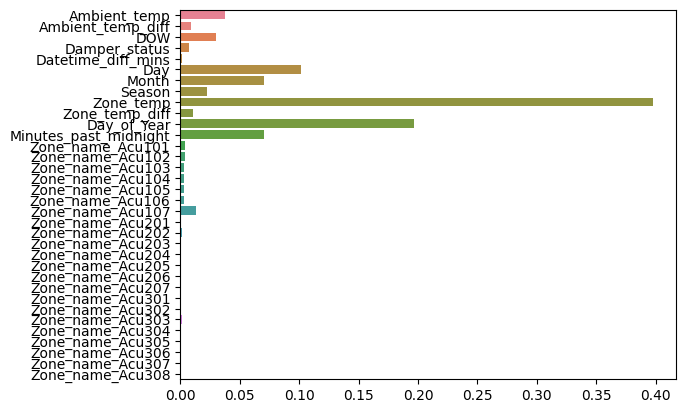

In [15]:
forest.fit(x_train1, y_train1)
sns.barplot(pd.DataFrame(forest.feature_importances_, index=features1).T, orient="h")

In [16]:
model_metrics["Building 1"][model_name] = calculate_metrics(forest, x_val1, y_val1)

              precision    recall  f1-score   support

         Off     0.9996    0.9996    0.9996     27615
          On     0.9999    0.9999    0.9999     76071

    accuracy                         0.9998    103686
   macro avg     0.9997    0.9997    0.9997    103686
weighted avg     0.9998    0.9998    0.9998    103686



### Building 2

<Axes: >

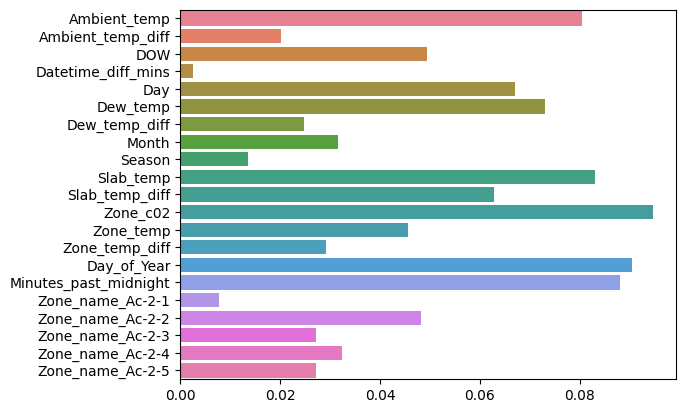

In [17]:
forest.fit(x_train2, y_train2)
sns.barplot(pd.DataFrame(forest.feature_importances_, index=features2).T, orient="h")

In [18]:
model_metrics["Building 2"][model_name] = calculate_metrics(forest, x_val2, y_val2)

              precision    recall  f1-score   support

         Off     0.9879    0.9836    0.9858     11577
          On     0.8928    0.9193    0.9059      1722

    accuracy                         0.9753     13299
   macro avg     0.9404    0.9514    0.9458     13299
weighted avg     0.9756    0.9753    0.9754     13299



### Building 3

<Axes: >

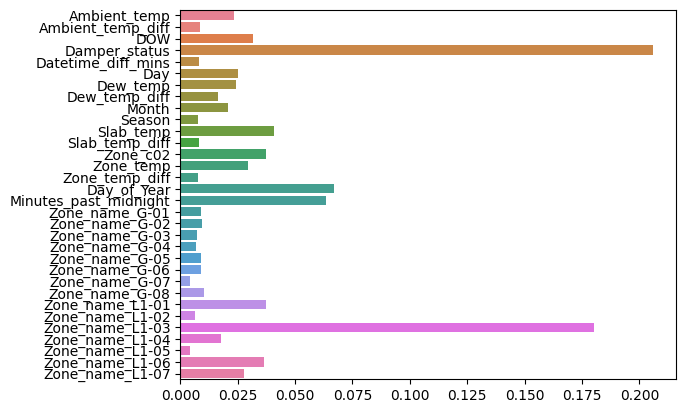

In [19]:
forest.fit(x_train3, y_train3)
sns.barplot(pd.DataFrame(forest.feature_importances_, index=features3).T, orient="h")

In [20]:
model_metrics["Building 3"][model_name] = calculate_metrics(forest, x_val3, y_val3)

              precision    recall  f1-score   support

         Off     0.9927    0.9965    0.9946     46202
          On     0.9890    0.9774    0.9832     15039

    accuracy                         0.9918     61241
   macro avg     0.9909    0.9869    0.9889     61241
weighted avg     0.9918    0.9918    0.9918     61241



## Model Performance
### Building 1

In [21]:
pd.DataFrame(model_metrics["Building 1"]).T

,Accuracy,f1,ROC AUC,PR AUC,Matthews
Decision Tree,0.999605,0.999731,0.999534,0.999693,0.998988
Random Forest,0.999788,0.999855,1.000000,1.000000,0.999457


### Building 2

In [22]:
pd.DataFrame(model_metrics["Building 2"]).T

,Accuracy,f1,ROC AUC,PR AUC,Matthews
Decision Tree,0.951651,0.827845,0.928727,0.702746,0.803219
Random Forest,0.975261,0.905866,0.992703,0.961081,0.891754


### Building 3

In [23]:
pd.DataFrame(model_metrics["Building 3"]).T

,Accuracy,f1,ROC AUC,PR AUC,Matthews
Decision Tree,0.987508,0.974584,0.983379,0.955889,0.966304
Random Forest,0.991787,0.983178,0.999449,0.998253,0.977775


## Model Tuning

Creating and evaluating all model variants takes a long time to complete from scratch. Data will be cached so that future runs will not take as long.

In [24]:
from mlmodel import SCORES
scores = list(SCORES)
tuned_metrics = {f"Building {n+1}": {} for n in range(3)}

### Decision Tree

In [25]:
from mlmodel import GridSearchDecisionTree
model_name = "Decision Tree"

#### Building 1

<Axes: xlabel='nodes'>

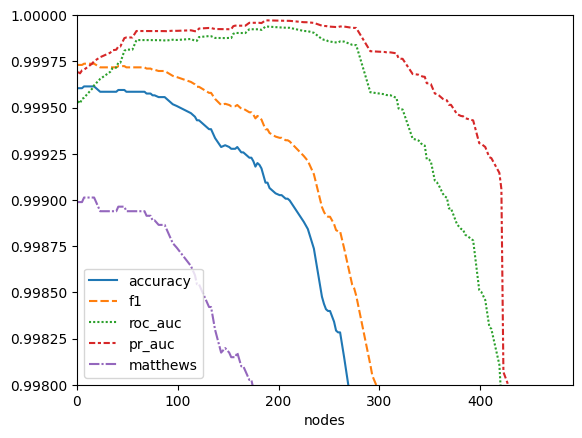

In [26]:
opt1 = GridSearchDecisionTree("building1", n_fits=-1)
opt1.fit(x_train1, y_train1, x_val1, y_val1)
opt1.save_results()

df = opt1.results
df = pd.DataFrame(df[scores], index=df["nodes"])
plt = sns.lineplot(df)
plt.set_xlim(0, len(df))
plt.set_ylim(0.998, 1.0)
display(plt)

In [27]:
tuned_metrics["Building 1"][model_name] = calculate_metrics(opt1.model, x_test1, y_test1)

              precision    recall  f1-score   support

         Off     0.9994    0.9993    0.9994     27253
          On     0.9998    0.9998    0.9998     76433

    accuracy                         0.9997    103686
   macro avg     0.9996    0.9996    0.9996    103686
weighted avg     0.9997    0.9997    0.9997    103686



#### Building 2

<Axes: xlabel='nodes'>

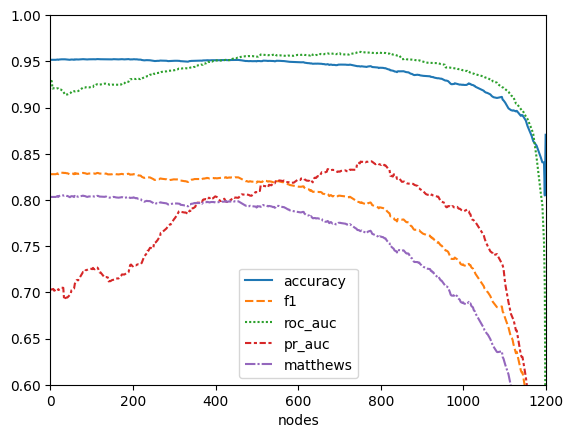

In [28]:
opt2 = GridSearchDecisionTree("building2", n_fits=-1)
opt2.fit(x_train2, y_train2, x_val2, y_val2)
opt2.save_results()

df = opt2.results
df = pd.DataFrame(df[scores], index=df["nodes"])
plt = sns.lineplot(df)
plt.set_xlim(0, len(df))
plt.set_ylim(0.6, 1.0)
display(plt)

In [29]:
tuned_metrics["Building 2"][model_name] = calculate_metrics(opt2.model, x_test2, y_test2)

              precision    recall  f1-score   support

         Off     0.9837    0.9644    0.9740     11559
          On     0.7911    0.8937    0.8393      1741

    accuracy                         0.9552     13300
   macro avg     0.8874    0.9291    0.9066     13300
weighted avg     0.9585    0.9552    0.9563     13300



#### Building 3

<Axes: xlabel='nodes'>

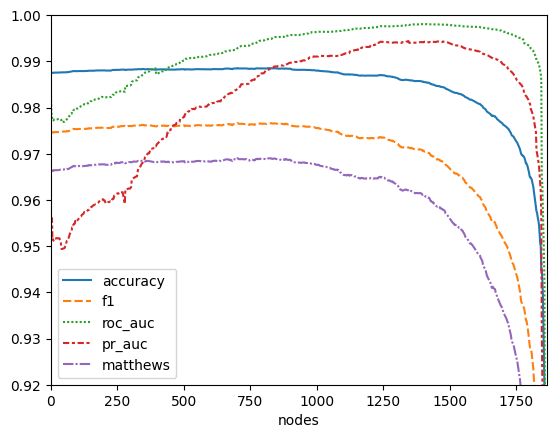

In [30]:
opt3 = GridSearchDecisionTree("building3", n_fits=-1)
opt3.fit(x_train3, y_train3, x_val3, y_val3)
opt3.save_results()

df = opt3.results
df = pd.DataFrame(df[scores], index=df["nodes"])
plt = sns.lineplot(df)
plt.set_xlim(0, len(df))
plt.set_ylim(0.92, 1.0)
display(plt)

In [31]:
tuned_metrics["Building 3"][model_name] = calculate_metrics(opt3.model, x_test3, y_test3)

              precision    recall  f1-score   support

         Off     0.9922    0.9927    0.9924     46088
          On     0.9778    0.9762    0.9770     15153

    accuracy                         0.9886     61241
   macro avg     0.9850    0.9844    0.9847     61241
weighted avg     0.9886    0.9886    0.9886     61241



### Random Forest

In [32]:
from mlmodel import GridSearchRandomForest
model_name = "Random Forest"

#### Building 1

In [33]:
opt1 = GridSearchRandomForest("building1", n_fits=-1)
opt1.fit(x_train1, y_train1, x_val1, y_val1)
opt1.save_results()

opt1.model.get_params()

  0%|          | 0/296 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
df = opt1.results
df = pd.DataFrame(df[scores], index=df["min_samples_split"])
plt = sns.lineplot(df)
#plt.set_xlim(0, df.index.max())
#plt.set_ylim(0.98, 1.0)
display(plt)

In [34]:
tuned_metrics["Building 1"][model_name] = calculate_metrics(opt1.model, x_test1, y_test1)

              precision    recall  f1-score   support

         Off     0.9997    0.9997    0.9997     27253
          On     0.9999    0.9999    0.9999     76433

    accuracy                         0.9999    103686
   macro avg     0.9998    0.9998    0.9998    103686
weighted avg     0.9999    0.9999    0.9999    103686



#### Building 2

100%|██████████| 165/165 [13:23<00:00,  4.87s/it]


<Axes: xlabel='min_samples_split'>

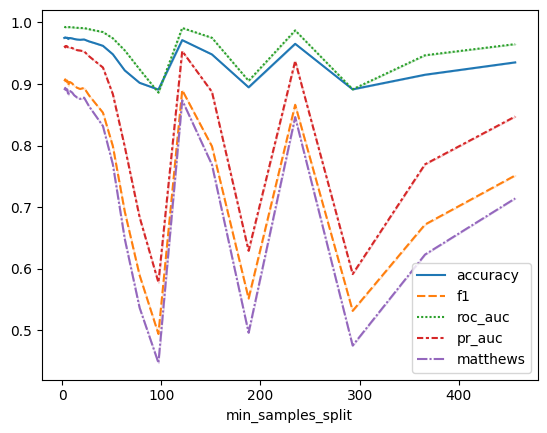

In [35]:
opt2 = GridSearchRandomForest("building2", n_fits=-1)
opt2.fit(x_train2, y_train2, x_val2, y_val2)
opt2.save_results()

opt2.model.get_params()

In [ ]:
df = opt2.results
df = pd.DataFrame(df[scores], index=df["min_samples_split"])
plt = sns.lineplot(df)
display(plt)

In [36]:
tuned_metrics["Building 2"][model_name] = calculate_metrics(opt2.model, x_test2, y_test2)

              precision    recall  f1-score   support

         Off     0.9868    0.9843    0.9855     11559
          On     0.8972    0.9127    0.9049      1741

    accuracy                         0.9749     13300
   macro avg     0.9420    0.9485    0.9452     13300
weighted avg     0.9751    0.9749    0.9750     13300



In [37]:
opt3 = GridSearchRandomForest("building3", n_fits=-1)
opt3.fit(x_train3, y_train3, x_val3, y_val3)
opt3.save_results()

opt3.model.get_params()

  1%|          | 3/328 [02:48<5:04:47, 56.27s/it]


KeyboardInterrupt: 

In [ ]:
df = opt3.results
df = pd.DataFrame(df[scores], index=df["min_samples_split"])
plt = sns.lineplot(df)
display(plt)

In [38]:
tuned_metrics["Building 3"][model_name] = calculate_metrics(opt3.model, x_test3, y_test3)

              precision    recall  f1-score   support

         Off     0.9941    0.9964    0.9952     46088
          On     0.9888    0.9821    0.9855     15153

    accuracy                         0.9928     61241
   macro avg     0.9915    0.9892    0.9904     61241
weighted avg     0.9928    0.9928    0.9928     61241



## Tuned Model Performance
### Building 1

In [39]:
pd.DataFrame(tuned_metrics["Building 1"]).T

,Accuracy,f1,ROC AUC,PR AUC,Matthews
Decision Tree,0.999672,0.999778,0.999791,0.999862,0.999154
Random Forest,0.999855,0.999902,1.000000,1.000000,0.999627


### Building 2

In [40]:
pd.DataFrame(tuned_metrics["Building 2"]).T

,Accuracy,f1,ROC AUC,PR AUC,Matthews
Decision Tree,0.955188,0.839266,0.920347,0.721008,0.815388
Random Forest,0.974887,0.904897,0.992399,0.961979,0.890475


### Building 3

In [41]:
pd.DataFrame(tuned_metrics["Building 3"]).T

,Accuracy,f1,ROC AUC,PR AUC,Matthews
Decision Tree,0.988619,0.976982,0.993015,0.983597,0.969423
Random Forest,0.992832,0.985465,0.999554,0.998825,0.980718
